Preparing data for semantic segmentation
===

In [1]:
import os
import json

import fiftyone as fo
import fiftyone.zoo as foz

import pandas as pd
from sklearn.model_selection import train_test_split

from loguru import logger

## Download COCO-2017 dataset

**Classes:**
  * person
  * car
  * bus
  * truck

* Filtering by size

In [5]:
# cleanup old datasets
for ds in fo.list_datasets():
    fo.delete_dataset(ds)

In [6]:
selected_classes = [
    "person", "car", "bus", "truck"
]

dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["train", "validation"],
    classes=selected_classes,
    max_samples=10000,
    only_matching=True,
    label_types=["segmentations"]
)


Found annotations at '/home/pyml/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Found annotations at '/home/pyml/fiftyone/coco-2017/raw/instances_val2017.json'
Only found 2930 (<10000) samples matching your requirements
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'train'
 100% |█████████████| 10000/10000 [31.2s elapsed, 0s remaining, 373.7 samples/s]      
Loading 'coco-2017' split 'validation'
 100% |███████████████| 2930/2930 [7.6s elapsed, 0s remaining, 382.4 samples/s]       
Dataset 'coco-2017-train-validation-10000' created


In [3]:
sample = dataset.first()

sample["ground_truth.detections"][0]

<Detection: {
    'id': '66fdff796b89378d4f29326a',
    'attributes': {},
    'tags': [],
    'label': 'bicycle',
    'bounding_box': [
        0.9574374999999999,
        0.55921875,
        0.042562499999999996,
        0.10275000000000001,
    ],
    'mask': array([[False, False, False, ...,  True,  True, False],
           [False, False, False, ...,  True,  True, False],
           [False, False, False, ...,  True,  True,  True],
           ...,
           [False, False, False, ...,  True,  True,  True],
           [False, False, False, ..., False,  True,  True],
           [False, False, False, ..., False, False, False]]),
    'confidence': None,
    'index': None,
    'supercategory': 'vehicle',
    'iscrowd': 0,
}>

bicycle 0.0030078125
bicycle 0.03295247395833333
bicycle 0.0021354166666666665
person 0.0907421875
<Detection: {
    'id': '66fe0279f08e2ab5d4cf8589',
    'attributes': {},
    'tags': [],
    'label': 'person',
    'bounding_box': [
        0.26045833333333335,
        0.21404687500000003,
        0.4286875,
        0.665171875,
    ],
    'mask': array([[False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           ...,
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False]]),
    'confidence': None,
    'index': None,
    'supercategory': 'person',
    'iscrowd': 0,
}>


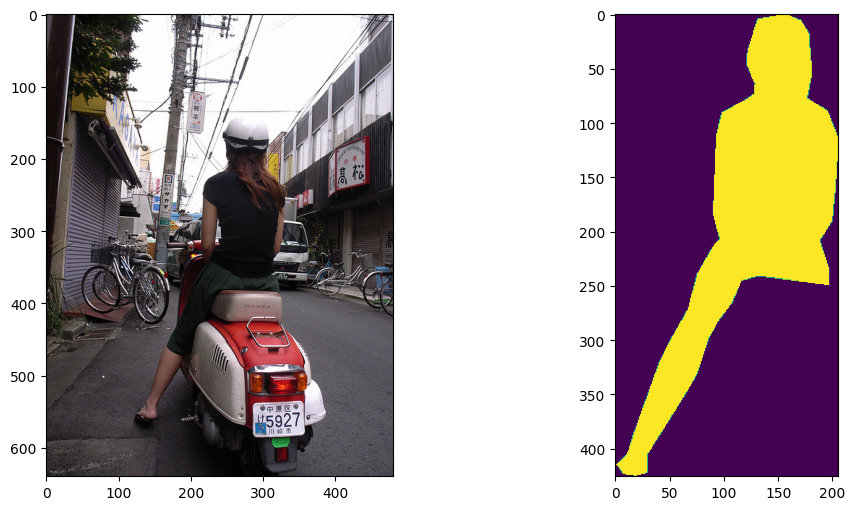

In [33]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open(sample["filepath"])
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, annot in enumerate(sample["ground_truth.detections"]):
    label = annot["label"]
    mask = annot["mask"]
    area_ratio = np.sum(mask) / (img.size[0] * img.size[1])
    print(label, area_ratio)
    if (label in selected_classes) and (area_ratio > 0.01):
        break


print(sample["ground_truth.detections"][idx])
axes[0].imshow(img)
mask_cropped = sample["ground_truth.detections"][idx]["mask"]
axes[1].imshow(mask_cropped)
plt.show()

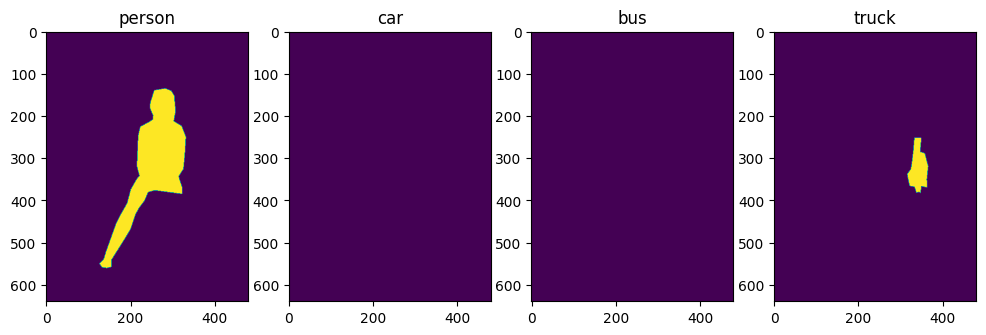

In [41]:

def reconstruct_fullsized_mask(mask_cropped, box, img_width, img_height):
    box = [
        int(box[0] * img_width),
        int(box[1] * img_height),
        mask_cropped.shape[1] + int(box[0] * img_width),
        mask_cropped.shape[0] + int(box[1] * img_height)
    ]

    mask = np.zeros((img_height, img_width), dtype=bool)
    mask[box[1]:box[3], box[0]:box[2]] = mask_cropped

    return mask


def generate_semantic_masks(sample, selected_classes):
    img = Image.open(sample["filepath"])
    img_width, img_height = img.size
    masks_by_label = {
        label: np.zeros((img_height, img_width), dtype=bool)
        for label in selected_classes
    }
    for annot in sample["ground_truth.detections"]:
        label = annot["label"]
        mask_cropped = annot["mask"]
        box = annot["bounding_box"]
        area_ratio = np.sum(mask_cropped) / (img.size[0] * img.size[1])

        if label not in selected_classes or area_ratio < 0.01:
            continue

        mask = reconstruct_fullsized_mask(mask_cropped, box, img_width, img_height)
        masks_by_label[label] = np.logical_or(masks_by_label[label], mask)

    return masks_by_label


masks = generate_semantic_masks(sample, selected_classes)
fig, axes = plt.subplots(1, len(masks), figsize=(12, 6))
for idx, (label, mask) in enumerate(masks.items()):
    axes[idx].imshow(mask)
    axes[idx].set_title(label)
plt.show()

In [48]:
from tqdm import tqdm

mask_dir = "data/semantic_masks"
os.makedirs(mask_dir, exist_ok=True)

list_samples = []
for sample in tqdm(dataset):
    filename = os.path.basename(sample["filepath"])
    filename = filename.replace('.jpg', '').replace('.png', '')
    masks = generate_semantic_masks(sample, selected_classes)
    # check if any label is present
    if all([not mask.any() for mask in masks.values()]):
        continue
    for label, mask in masks.items():
        mask_path = os.path.join(mask_dir, f"{filename}_{label}.png")
        Image.fromarray(mask.astype(np.uint8) * 255).save(mask_path)
    list_samples.append({
        "imagepath": sample["filepath"],
        "tag": sample["tags"][0]
    })

logger.info(f"Generated {len(list_samples)} samples with semantic masks")

100%|██████████| 12930/12930 [00:52<00:00, 246.55it/s]
2024-10-02 23:04:05.560 | INFO     | __main__:<module>:22 - Generated 11152 samples with semantic masks


In [54]:
df = pd.DataFrame(list_samples)
df.head()

,imagepath,tag
0,/home/pyml/fiftyone/coco-2017/train/data/00000...,train
1,/home/pyml/fiftyone/coco-2017/train/data/00000...,train
2,/home/pyml/fiftyone/coco-2017/train/data/00000...,train
3,/home/pyml/fiftyone/coco-2017/train/data/00000...,train
4,/home/pyml/fiftyone/coco-2017/train/data/00000...,train


<Axes: title={'center': 'Number of samples per split'}, xlabel='tag'>

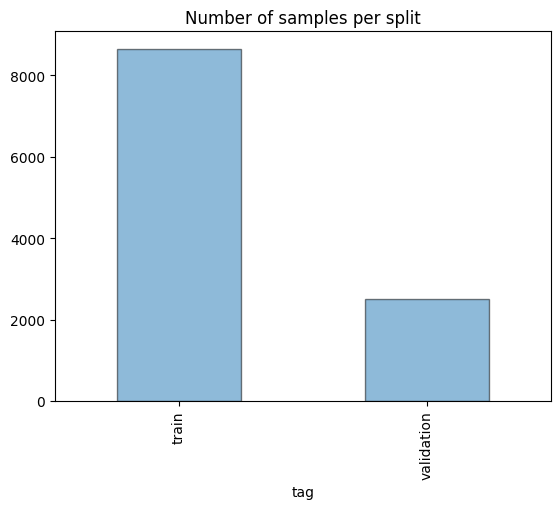

In [50]:
# bar plot of train/test/validation split
df["tag"].value_counts().plot(
    kind="bar", alpha=0.5, edgecolor="black",
    title="Number of samples per split"
)

In [55]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of Train samples: {len(df[df['tag'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['tag'] == 'validation'])}")

2024-10-02 23:10:13.895 | INFO     | __main__:<module>:1 - Number of samples: 11152
2024-10-02 23:10:13.899 | INFO     | __main__:<module>:2 - Number of Train samples: 8643
2024-10-02 23:10:13.900 | INFO     | __main__:<module>:3 - Number of Validation samples: 2509


In [56]:
# use current validation set as test set
df_test = df[df["tag"] == "validation"].reset_index(drop=True)
df_test = df_test.drop(columns=["tag"])
df_test["split"] = "test"

# split train -> train/val (80%/20%)
df_train = df[df["tag"] == "train"].reset_index(drop=True)
df_train = df_train.drop(columns=["tag"])
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
df_train["split"] = "train"
df_val["split"] = "val"

# concatenate
df = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)

df.to_csv("data/data.csv", index=False)

In [57]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of Train samples: {len(df[df['split'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['split'] == 'val'])}")
logger.info(f"Number of Test samples: {len(df[df['split'] == 'test'])}")


2024-10-02 23:11:10.757 | INFO     | __main__:<module>:1 - Number of samples: 11152
2024-10-02 23:11:10.759 | INFO     | __main__:<module>:2 - Number of Train samples: 6914
2024-10-02 23:11:10.760 | INFO     | __main__:<module>:3 - Number of Validation samples: 1729
2024-10-02 23:11:10.761 | INFO     | __main__:<module>:4 - Number of Test samples: 2509
